# Fill Method Testing

Load Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('C:\\Users\\Peter\\Desktop\\Sample Time Series Data.csv').set_index('Index')

Note: Data has been preprocessed to remove any holes, normailized [0,1] and has the columns renamed for confidentiality.

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
Index,,,,,,,,,,,,,,,,,,,,,
0,0.361525,0.384778,0.630541,0.015482,0.110267,0.401254,0.097511,0.099071,0.105769,0.383186,...,0.234916,0.027748,0.252627,0.144951,0.225623,0.285647,0.326815,0.000000,0.231849,0.000000
1,0.589188,0.489547,0.495004,0.004977,0.118513,0.545455,0.122807,0.306669,0.126923,0.675801,...,0.430378,0.000000,0.235979,0.661341,0.222465,0.292349,0.372612,0.516266,0.407927,0.422881
2,0.586796,0.421424,0.529490,0.009953,0.204484,0.581505,0.474092,0.312135,1.000000,0.611937,...,0.450764,0.054686,0.287409,0.566237,0.293479,0.012781,0.388511,0.709134,0.433901,0.428552
3,0.547744,0.385718,0.693825,0.000000,0.237143,0.663009,0.205744,0.265335,0.305769,0.839294,...,0.334995,0.213162,0.287034,1.000000,0.123299,0.236847,0.247761,0.564223,0.490325,0.463261
4,0.525636,0.387597,0.578273,0.096212,0.312078,0.801724,0.390249,0.573717,0.188462,0.616814,...,0.245426,0.369176,0.241046,0.714184,0.357736,0.170822,0.452863,0.658221,0.432728,0.425298


Place 'Nan' values in the data.

In [4]:
def input_nan(x,pct,lst):
    #Select the middle of the data without the first and last items.
    #Because we are testing Forward and Backward fill methods we can not have 'Nan' values in the 0 or -1 positions.
    xn = x.iloc[1:-1].copy()
    
    #Replace with Nan's.
    n = int((len(x))*(pct - xn.isna().mean()))
    idxs = np.random.choice(len(xn), max(n,0), replace=False, p=xn.notna()/xn.notna().sum())
    xn.iloc[idxs] = np.nan
    
    #Add the first and last items back to the data.
    xx = [x.iloc[0]] + list(xn) + [x.iloc[-1]]
    
    #Output as list or Dataframe.
    if lst == 0:
        return xx
    else:
        return pd.DataFrame(xx,index=[x.index])

Lets look at what this Function does.

In [5]:
print(input_nan(data['0'], pct=.2,lst=1))

              0
Index          
0      0.361525
1      0.589188
2      0.586796
3      0.547744
4      0.525636
5           NaN
6           NaN
7      0.705270
8      0.540756
9      0.526853
10     0.563294
11     0.345473
12     0.419960
13     0.514297
14     0.594181
15          NaN
16          NaN
17     0.536567
18     0.707053
19     1.000000
20     0.508624
21     0.250853
22          NaN
23     0.168569
24     0.254002
25     0.111418
26     0.232121
27          NaN
28          NaN
29     0.230920
30     0.142194
31     0.207708
32     0.150635
33     0.140021
34     0.142584
35     0.021037
36     0.306597
37     0.244003
38     0.257487


Fill Hole Methods Tested:
0. Forward Fill
1. Backward Fill
2. Linear Interpolation
3. Quadratic interpolation
4. Mean of nearest neighbors
5. Mean of seasonal couterparts
6. Rolling Mean

Lets load additional Moddules.

In [6]:
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

In [7]:
totalerror = []

for i in list(data.columns):
    errors = []
    df_orig = data.copy()
    df = df_orig.copy()
    df[i] = input_nan(df[i], pct=.2,lst=0)
    
    ## 0. Forward Fill --------------------------
    df_ffill = df.ffill()
    error = np.round(mean_squared_error(df_orig[i], df_ffill[i]), 2)
    errors.append(error)

    ## 1. Backward Fill -------------------------
    df_bfill = df.bfill()
    error = np.round(mean_squared_error(df_orig[i], df_bfill[i]), 2)
    errors.append(error)

    ## 2. Linear Interpolation ------------------
    df['rownum'] = np.arange(df.shape[0])
    df_nona = df.dropna(subset = [i])
    f = interp1d(df_nona['rownum'], df_nona[i])
    df['linear_fill'] = f(df['rownum'])
    error = np.round(mean_squared_error(df_orig[i], df['linear_fill']), 2)
    errors.append(error)

    ## 3. Cubic Interpolation --------------------
    f2 = interp1d(df_nona['rownum'], df_nona[i], kind='cubic')
    df['cubic_fill'] = f2(df['rownum'])
    error = np.round(mean_squared_error(df_orig[i], df['cubic_fill']), 2)
    errors.append(error)

    ## 4. Mean of 'n' Nearest Past Neighbors ------
    def knn_mean(ts, n):
        out = np.copy(ts)
        for i, val in enumerate(ts):
            if np.isnan(val):
                n_by_2 = np.ceil(n/2)
                lower = np.max([0, int(i-n_by_2)])
                upper = np.min([len(ts)+1, int(i+n_by_2)])
                ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
                out[i] = np.nanmean(ts_near)
        return out

    df['knn_mean'] = knn_mean(df[i].values, 8)
    error = np.round(mean_squared_error(df_orig[i], df['knn_mean']), 2)
    errors.append(error)
    
    ## 5. Seasonal Mean ----------------------------
    def seasonal_mean(ts, n, lr=0.7):
        out = np.copy(ts)
        for i, val in enumerate(ts):
            if np.isnan(val):
                ts_seas = ts[i-1::-n]  # previous seasons only
                if np.isnan(np.nanmean(ts_seas)):
                    ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
                out[i] = np.nanmean(ts_seas) * lr
        return out

    df['seasonal_mean'] = seasonal_mean(df[i], n=12, lr=1.25)
    error = np.round(mean_squared_error(df_orig[i], df['seasonal_mean'].fillna(0)), 2)
    errors.append(error)
    
    ## 6. Rolling Mean ----------------------------    
    navals = df[i].isnull().astype(int).groupby(df[i].notnull().astype(int).cumsum()).sum().max()
    df['Mean Fix'] = df[i].fillna(df[i].rolling(navals+1,min_periods=1,center=True).mean())
    error = np.round(mean_squared_error(df_orig[i], df['Mean Fix']), 2)
    errors.append(error)
    
    totalerror.append(errors)

In [8]:
import matplotlib.pyplot as plt

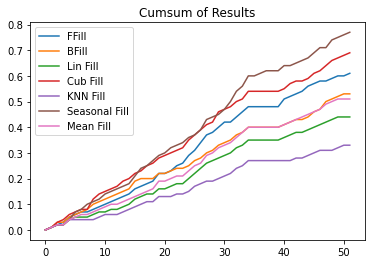

In [9]:
te = pd.DataFrame(totalerror,columns=['FFill','BFill','Lin Fill','Cub Fill','KNN Fill','Seasonal Fill','Mean Fill']) 
plt.plot(te.cumsum())
plt.legend(te.columns)
plt.title('Cumsum of Results')
plt.show()

From the results, we see that the KNN method of fill returns the best results. 